<a href="https://colab.research.google.com/github/0hee0/2022-HCI-Capstone/blob/main/Depression_Risk_Prediction_Using_LSTM_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📄 [Predicting the Risk of Depression Based on ECG Using RNN](https://www.hindawi.com/journals/cin/2021/1299870/)

In [ ]:
!nvidia-smi

Mon Nov 28 04:43:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

In [ ]:
!unzip --qq ECG5000.zip

In [ ]:
!pip install arff2pandas==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement arff2pandas==1.0.1 (from versions: none)
ERROR: No matching distribution found for arff2pandas==1.0.1


In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 27.6 MB/s 


In [ ]:
!pip install -qq -U pandas

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

numpy      : 1.21.6
pandas     : 1.3.5
torch      : 1.12.1+cu113
arff2pandas: not installed



In [ ]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
# from arff2pandas import a2p
from scipy.io.arff import loadarff


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
with open('ECG5000_TRAIN.arff') as f:
  train_raw_data = loadarff(f)
  train = pd.DataFrame(train_raw_data[0])

In [ ]:
with open('ECG5000_TEST.arff') as f:
  test_raw_data = loadarff(f)
  test = pd.DataFrame(test_raw_data[0])

In [ ]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [ ]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


In [ ]:
CLASS_NORMAL = 1
CLASS_PVC = 2
class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

#DATA PREPROCESSING


In [ ]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MaxAbsScaler().fit(df)
# scaler = MinMaxScaler().fit(df)

scaled_df = scaler.transform(df)

df = pd.DataFrame(scaled_df, columns=new_columns)

In [ ]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,0.218405,-0.147879,-0.661351,-0.793251,-0.774378,-0.717154,-0.628076,-0.417456,-0.368435,-0.247460,...,0.226822,0.279883,0.356963,0.346304,0.253625,0.276956,0.348523,0.284328,-0.140491,0.2
1,-0.296991,-0.531785,-0.831393,-0.793575,-0.653920,-0.479258,-0.355406,-0.363318,-0.255152,-0.102712,...,0.242037,0.224834,0.232015,0.222505,0.191933,0.215183,0.198233,0.249177,0.108012,0.2
2,-0.176502,-0.474592,-0.720055,-0.763490,-0.742701,-0.642637,-0.430268,-0.296368,-0.321120,-0.150417,...,0.260378,0.321925,0.312075,0.281338,0.179244,0.155566,0.169641,0.206817,-0.111386,0.2
3,0.089898,-0.235723,-0.630523,-0.739565,-0.756703,-0.666373,-0.540095,-0.418612,-0.414641,-0.247653,...,0.130841,0.142480,0.217823,0.270529,0.248546,0.249154,0.294385,0.373505,0.003221,0.2
4,-0.177904,-0.461206,-0.736240,-0.741636,-0.633415,-0.448883,-0.360986,-0.364798,-0.225987,-0.093840,...,0.198743,0.200619,0.234650,0.305369,0.285384,0.285277,0.208280,0.283675,0.234349,0.2


#EXPLORATION OF DATASET

In [ ]:
df.target.value_counts()

0.2    2919
0.4    1767
0.8     194
0.6      96
1.0      24
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


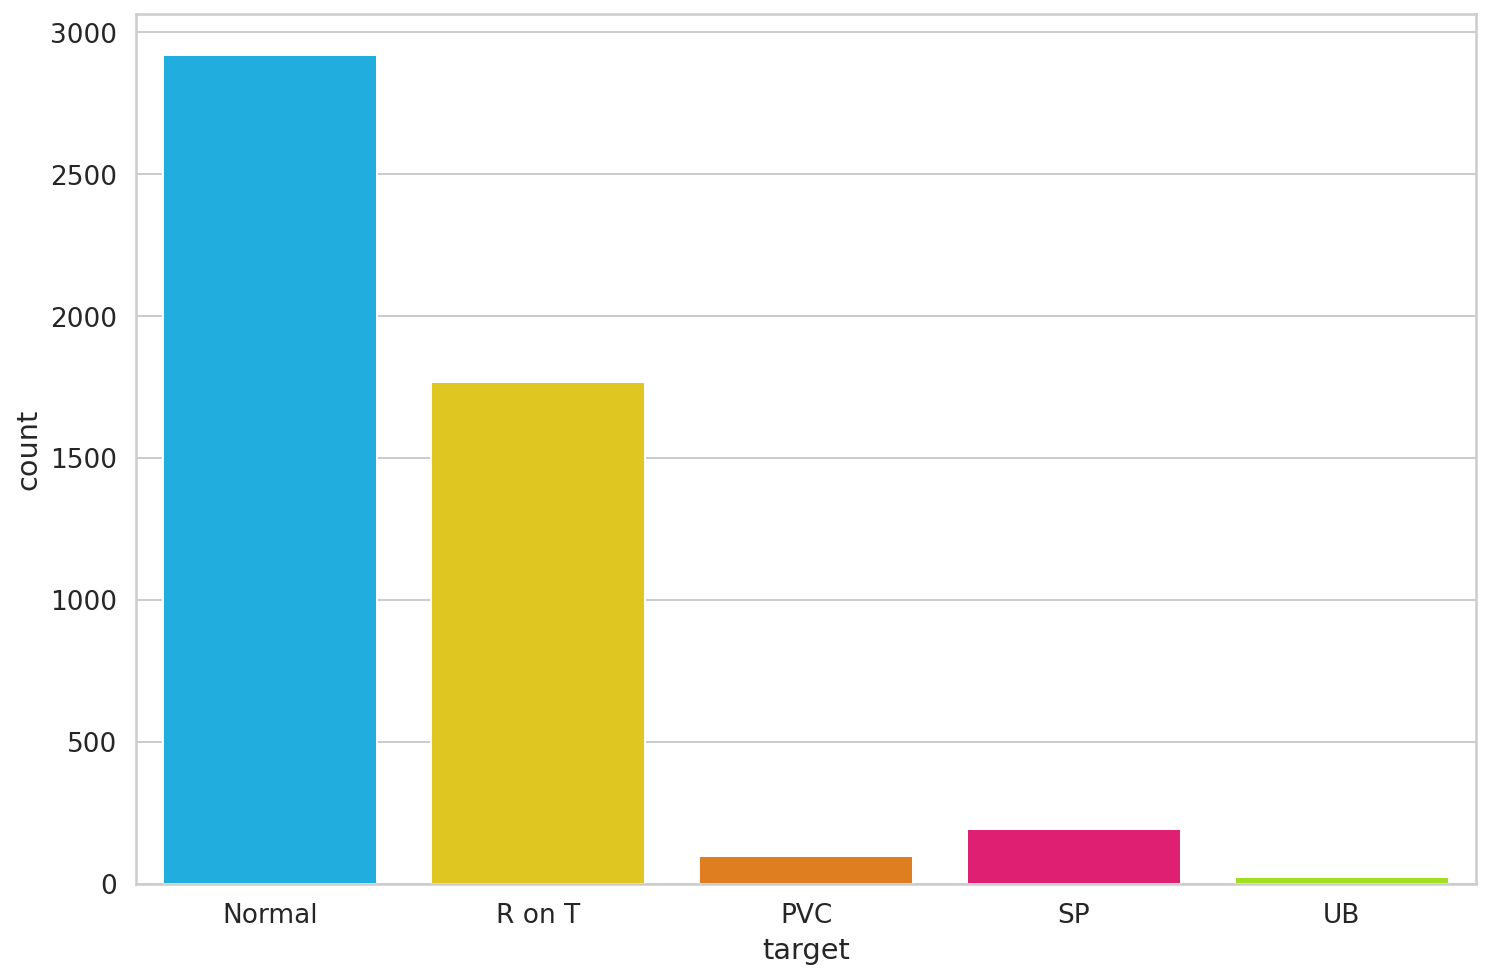

In [ ]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

##Time-Series Graph for each Class

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation) [0]
  over_line = (smooth_path + path_deviation) [0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
      path_deviation.index,
      under_line,
      over_line,
      alpha=.125
  )
  ax.set_title(class_name)

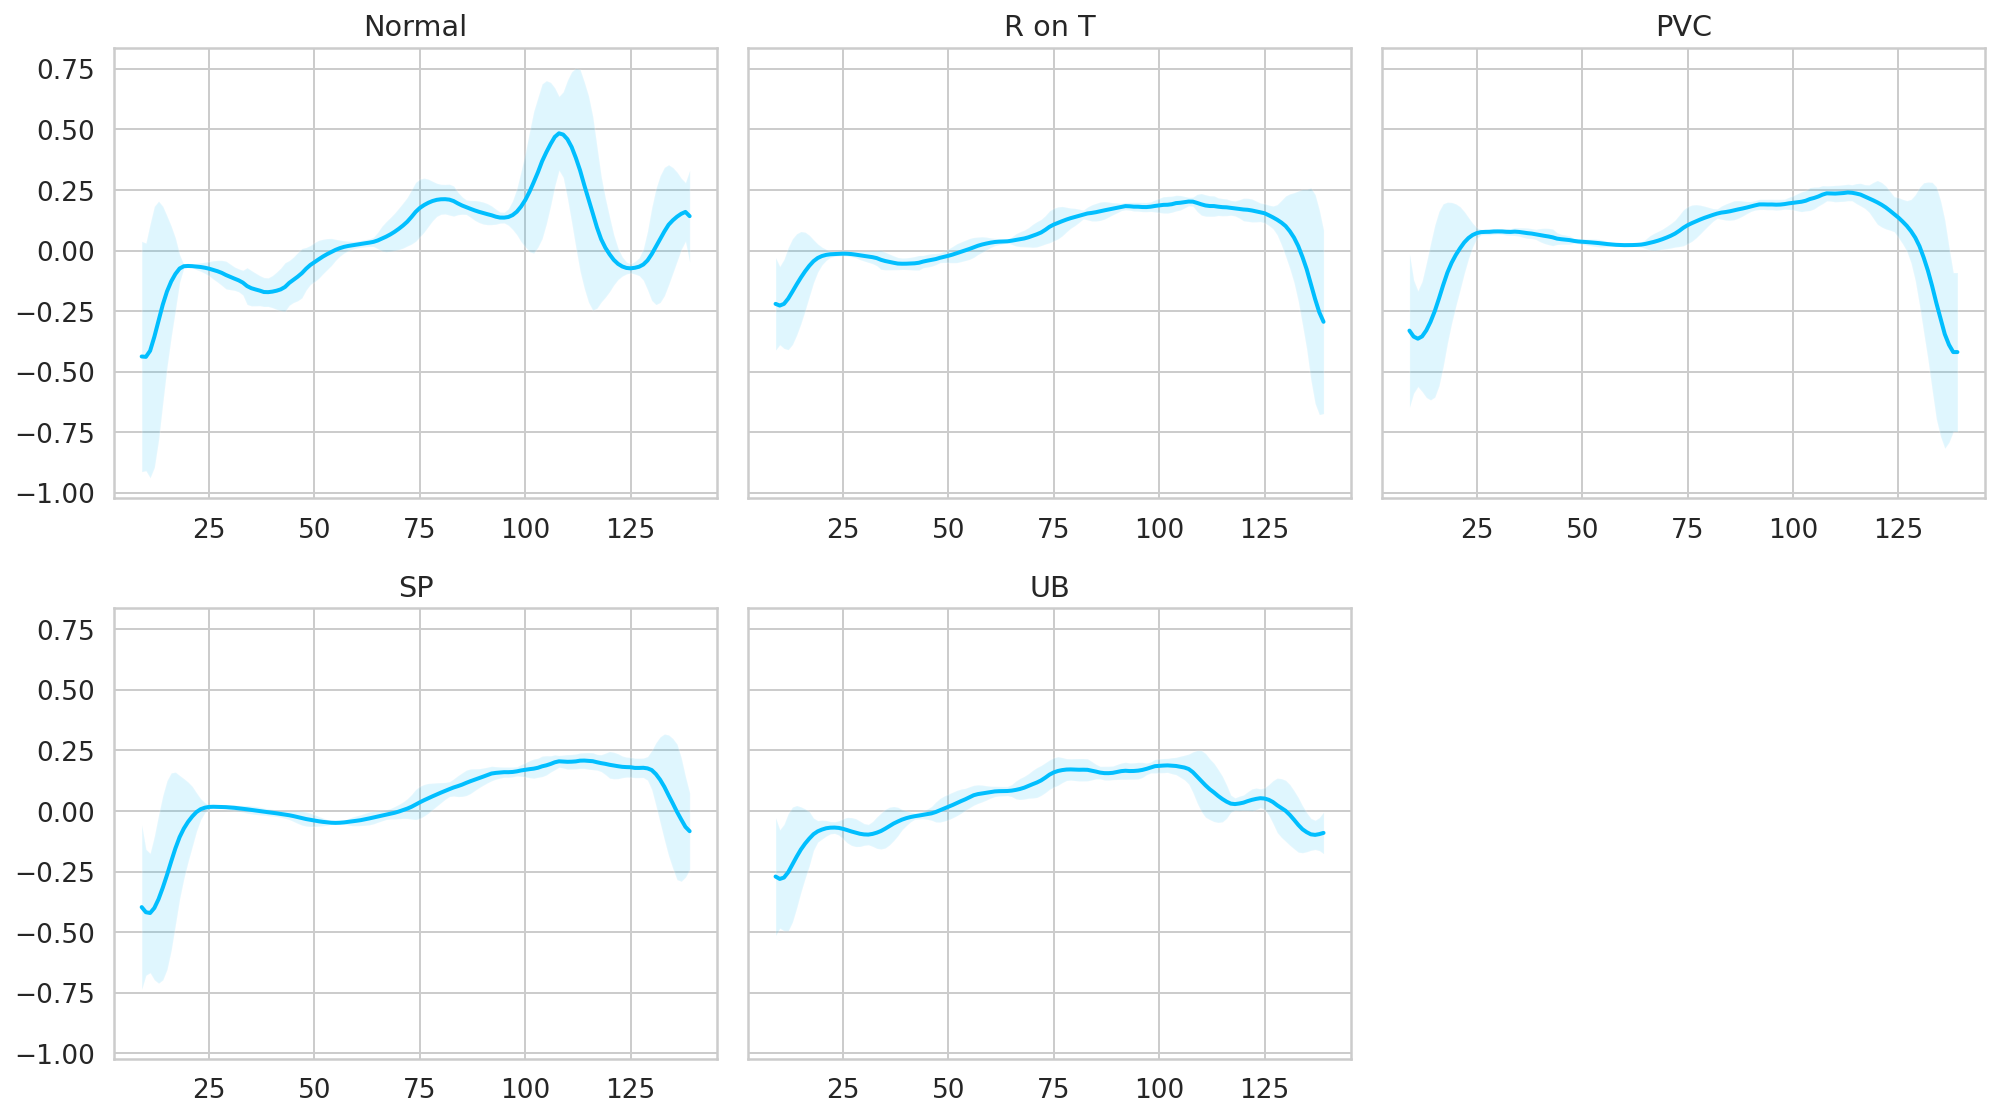

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [ ]:
type(df.target.unique()[0])

numpy.float64

In [ ]:
df.target.unique()

array([0.2, 0.6, 0.4, 0.8, 1. ])

In [ ]:
# CLASS_NORMAL
normal_df = df[df.target == 0.2].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [ ]:
abnormal_df = df[df.target != 0.2].drop(labels='target', axis=1)
abnormal_df.shape

(2081, 140)

In [ ]:
pvc_df = df[df.target == 0.4].drop(labels='target', axis=1)
pvc_df.shape

(1767, 140)

In [ ]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

In [ ]:
val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_abnormal_dataset, _, _ = create_dataset(abnormal_df)
test_pvc_dataset, _, _ = create_dataset(pvc_df)

##AUTOENCODER

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn3 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn3 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

#TRAINING

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs): 
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)
    

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 17.513767140183607 val loss 15.472171441686845
Epoch 2: train loss 15.133205464942376 val loss 13.855127009108612
Epoch 3: train loss 14.230192971681213 val loss 12.10065266703583
Epoch 4: train loss 10.482482144545278 val loss 9.07648861855777
Epoch 5: train loss 8.64674161231023 val loss 9.149749633802083
Epoch 6: train loss 7.902775948300375 val loss 7.9093075384458995
Epoch 7: train loss 7.53779186408686 val loss 9.35683972680935
Epoch 8: train loss 7.084927383904878 val loss 6.694823716687668
Epoch 9: train loss 6.94224128873057 val loss 6.4010466390095475
Epoch 10: train loss 6.650436061661554 val loss 6.385032518731856
Epoch 11: train loss 6.35302708332503 val loss 6.023241393802109
Epoch 12: train loss 6.295558110690319 val loss 6.4290305437081505
Epoch 13: train loss 6.135704939137635 val loss 5.880821588503216
Epoch 14: train loss 6.006721675996577 val loss 5.64360526153252
Epoch 15: train loss 6.165104436182486 val loss 6.183493611755631
Epoch 16: train l

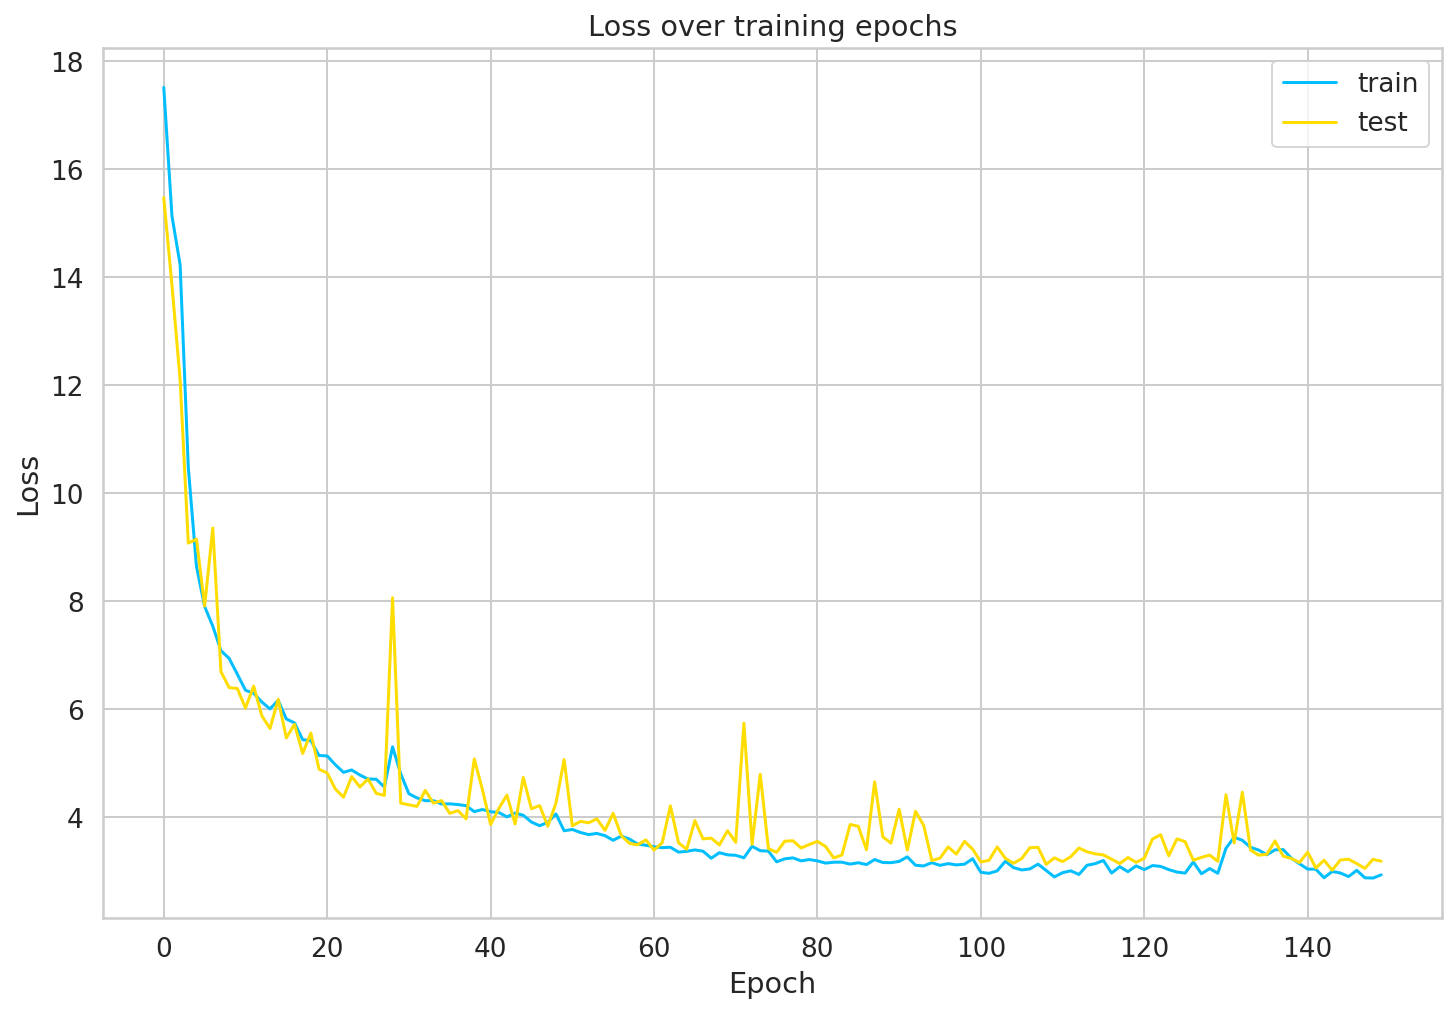

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
MODEL_PATH = 'model_maxabs-scaling.pth'

torch.save(model, MODEL_PATH)

In [ ]:
!gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
To: /content/drive/MyDrive/Colab Notebooks/2022 7학기 HCI 개론/캡스톤디자인/model.pth
100% 3.98M/3.98M [00:00<00:00, 191MB/s]


In [ ]:
model = torch.load('model_maxabs-scaling.pth')
model = model.to(device)

#Choosing Threshold
###Checking the Accuracy

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


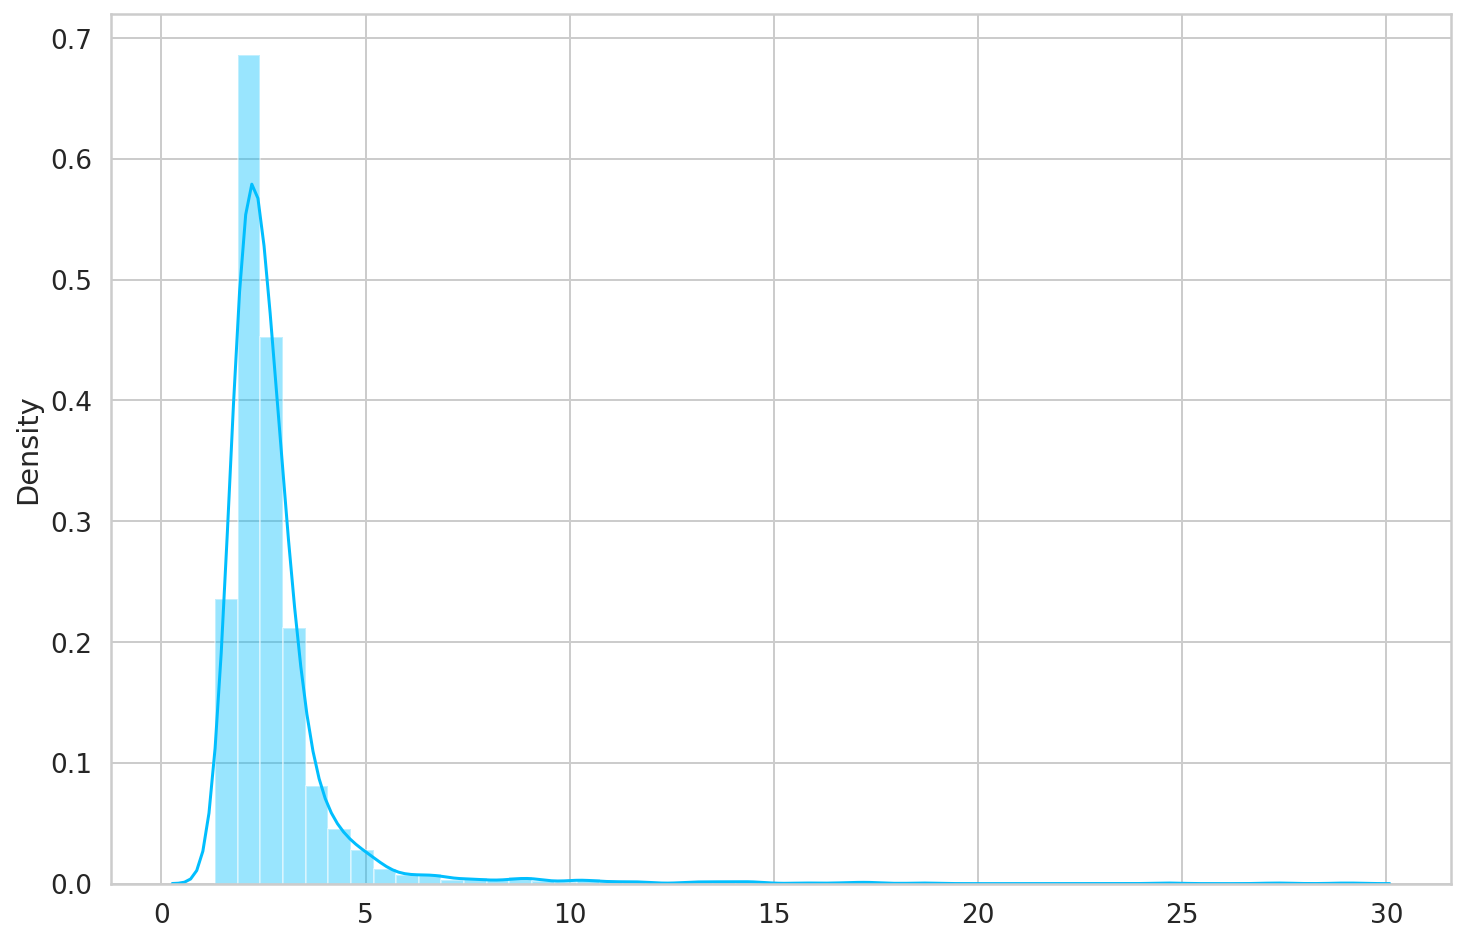

In [ ]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 12

#For Normal Heartbeat Prediction

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


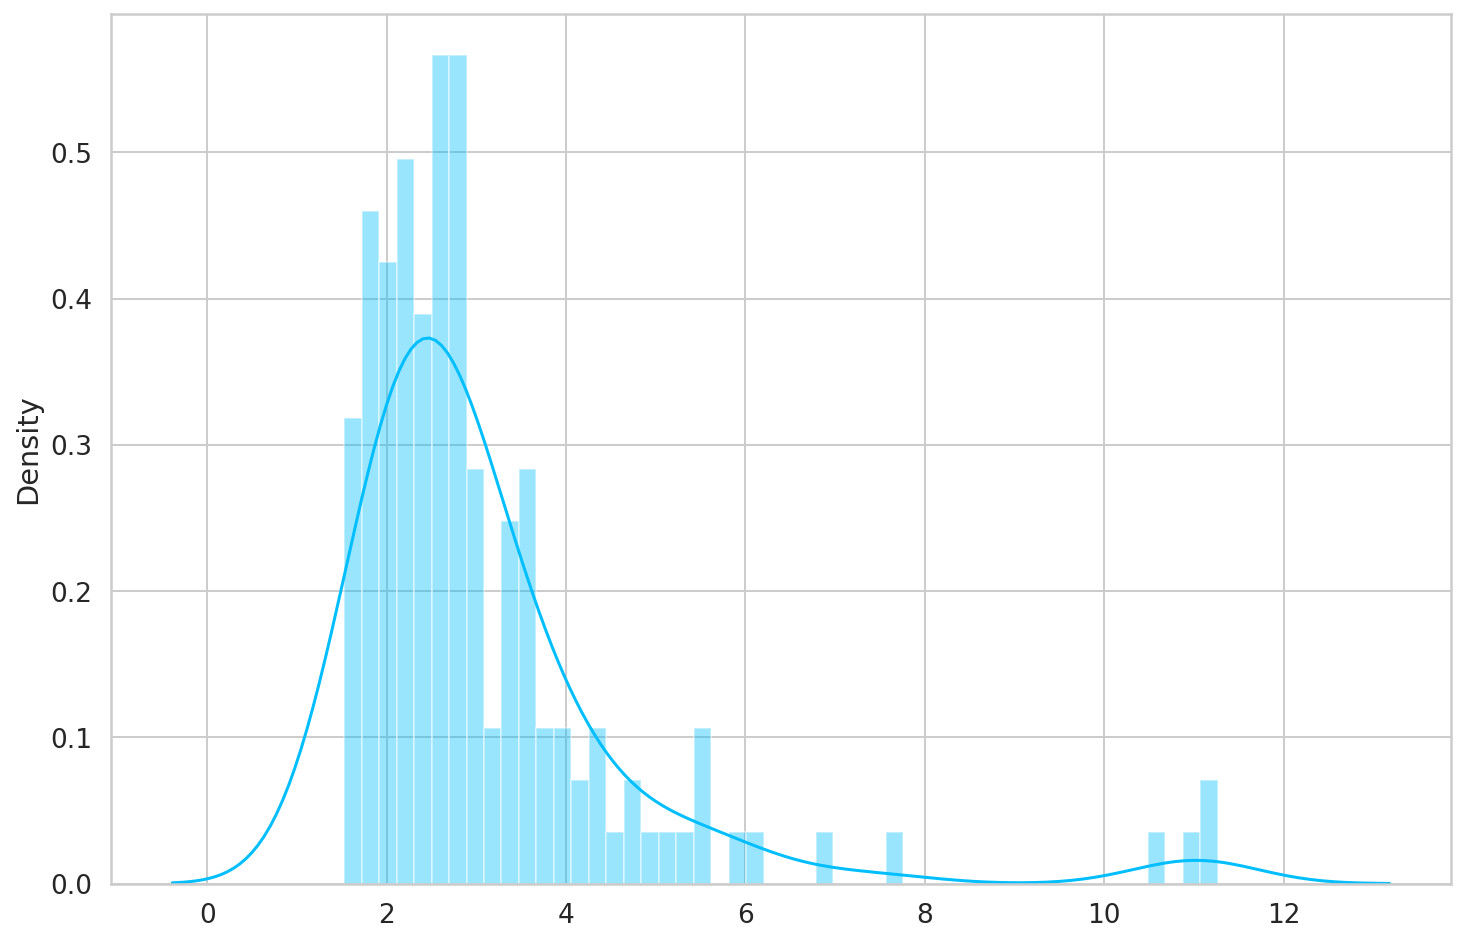

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 141/145


##For Risky Heartbeat Prediction

In [ ]:
pvc_dataset = test_pvc_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, pvc_dataset)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


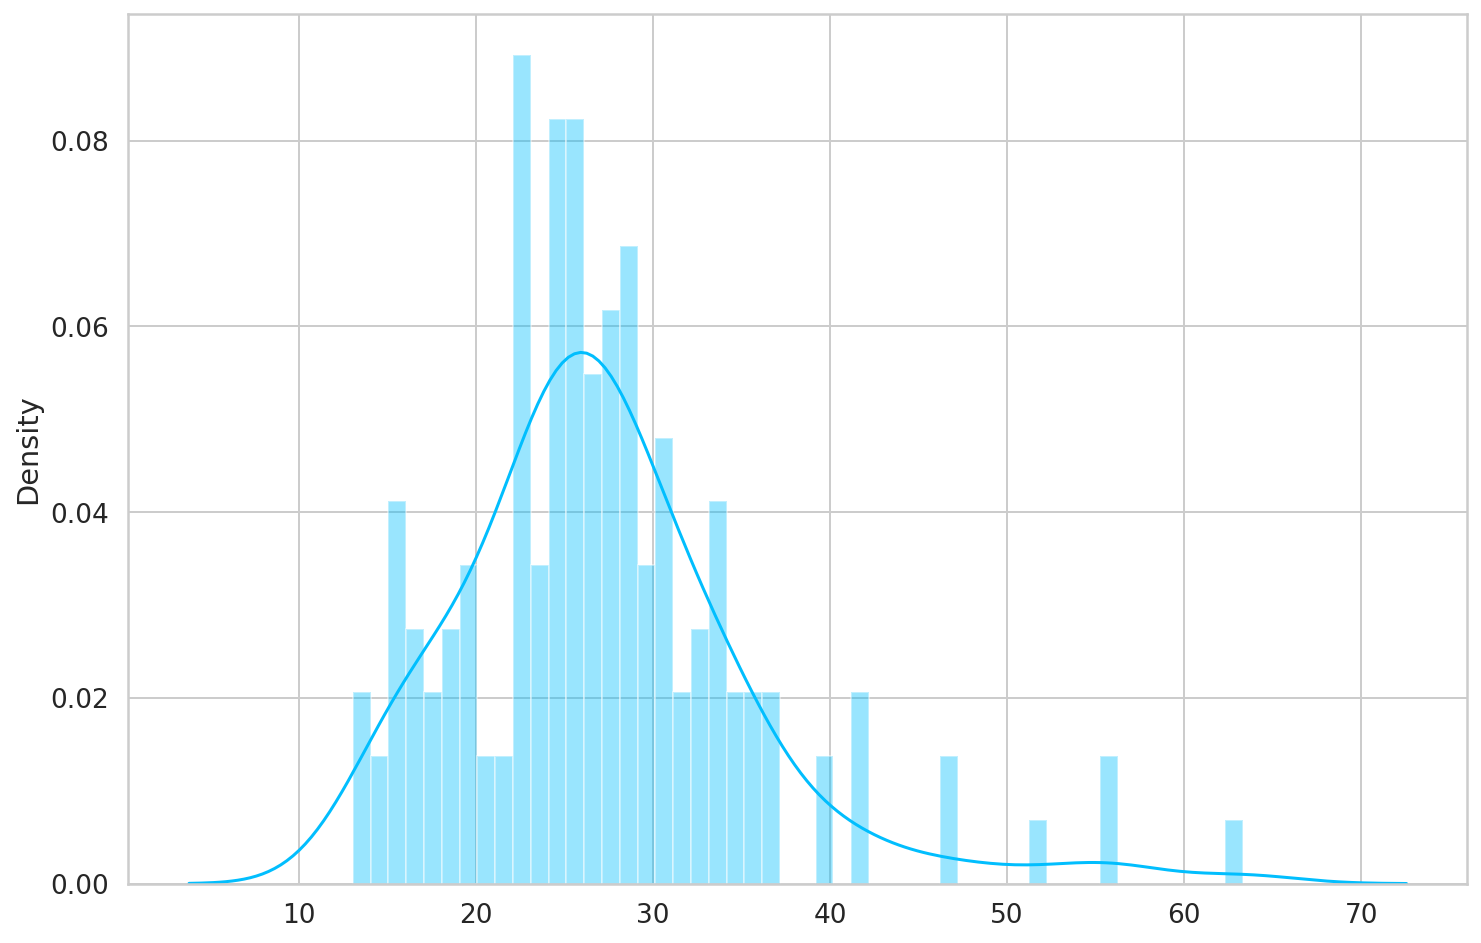

In [ ]:
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct pvc predictions: {correct}/{len(pvc_dataset)}')

Correct pvc predictions: 145/145


#Time Series Prediction: Normal vs Risky

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  print(pred_losses[0], "PVC:", pred_losses[0] > THRESHOLD)

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

1.7349114418029785 PVC: False
3.6802470684051514 PVC: False
2.0625271797180176 PVC: False
2.707711935043335 PVC: False
1.7614973783493042 PVC: False
2.5481348037719727 PVC: False
33.845542907714844 PVC: True
29.98105239868164 PVC: True
29.932281494140625 PVC: True
23.833995819091797 PVC: True
32.38481903076172 PVC: True
19.292551040649414 PVC: True


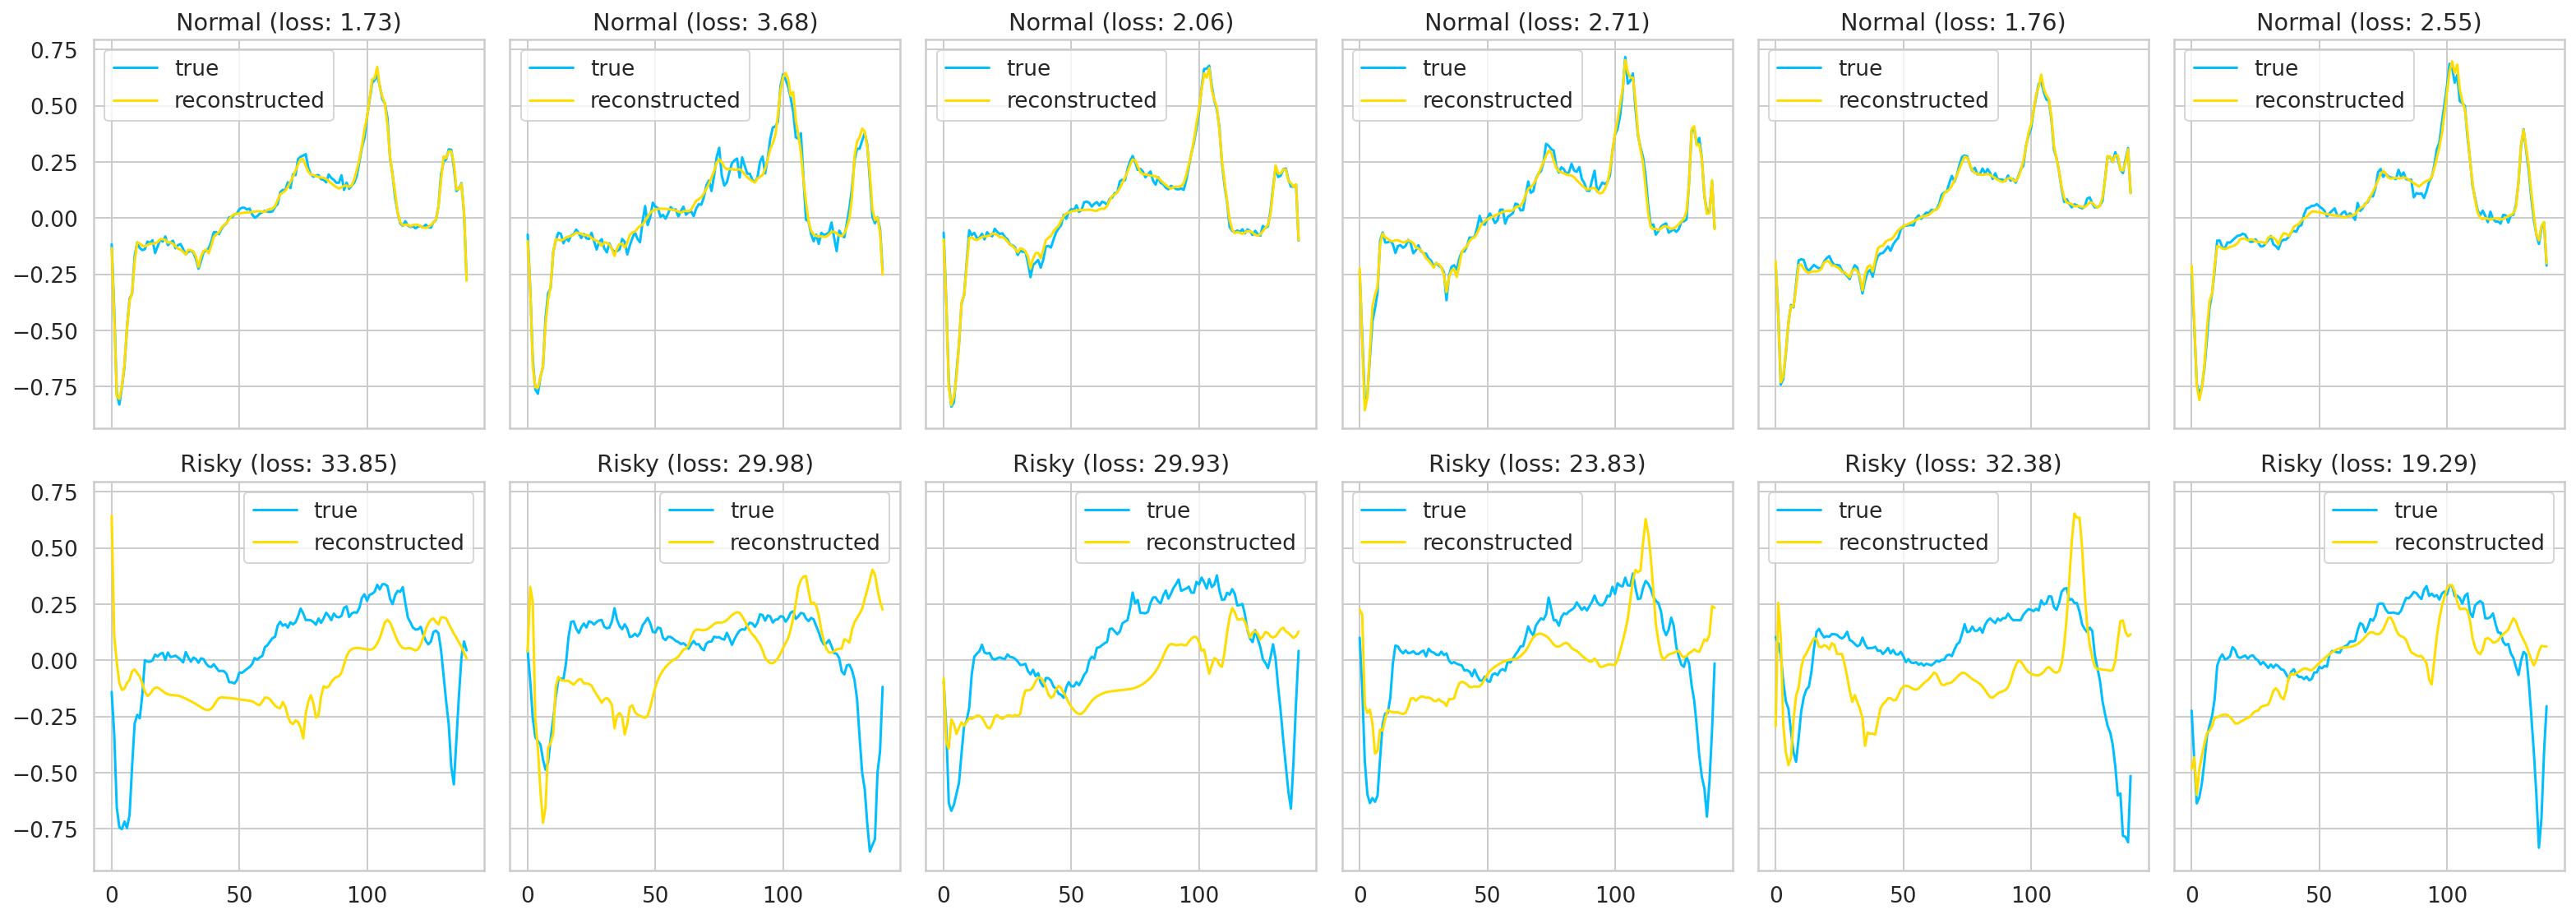

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_pvc_dataset[:6]):
  plot_prediction(data, model, title='Risky', ax=axs[1, i])

fig.tight_layout();

#Time Series Prediction: Abnormal vs Risky

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_abnormal_dataset[:6]):
  plot_prediction(data, model, title='Abnormal', ax=axs[0, i])

for i, data in enumerate(test_pvc_dataset[:6]):
  plot_prediction(data, model, title='Risky', ax=axs[1, i])

fig.tight_layout();